<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/Revnb_75_25_Update_H2_T12_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [2]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

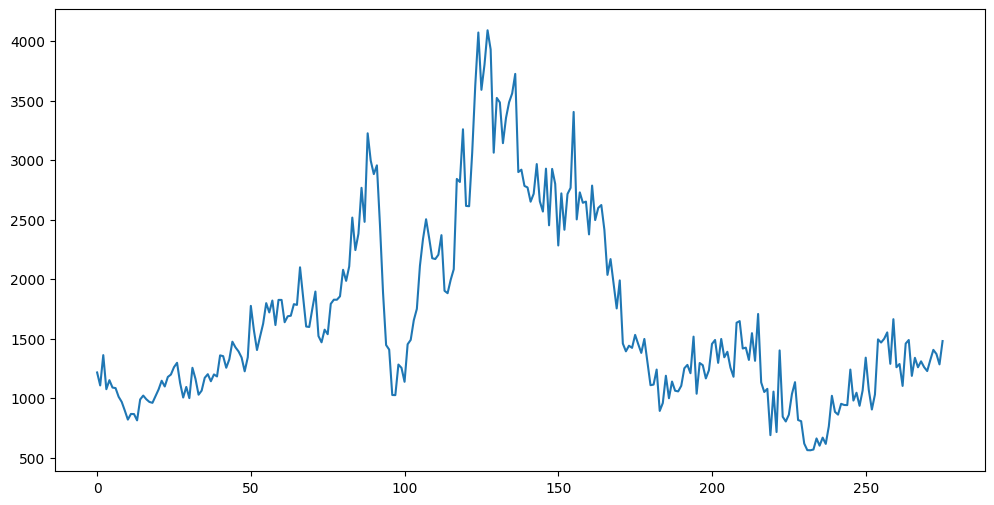

In [4]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [5]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 211
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
time_steps = 12
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [7]:
ytest = test
ytrain = train

In [8]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [9]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (199, 12, 1)
y_train.shape:  (199, 1)
X_test.shape:  (65, 12, 1)
y_test.shape:  (65, 1)


In [11]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [13]:
def objective(trial):
    # Define the search space
    lstm_units_1 = trial.suggest_categorical('lstm_units_1', [32, 64, 128])
    lstm_units_2 = trial.suggest_categorical('lstm_units_2', [32, 64, 128])
    dropout_rate_1 = trial.suggest_categorical('dropout_rate_1', [0.1, 0.2, 0.3, 0.4, 0.5])
    dropout_rate_2 = trial.suggest_categorical('dropout_rate_2', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model with 2 hidden layers
        model = Sequential([
            LSTM(units=lstm_units_1, return_sequences=True, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate_1),
            LSTM(units=lstm_units_2),
            Dropout(dropout_rate_2),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [14]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-15 07:26:10,726] A new study created in memory with name: no-name-9c161684-ec16-43cc-94c7-203d6d40980f


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 1: MSE = 0.0213
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 2: MSE = 0.0315


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step
Fold 3: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 4: MSE = 0.0168
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2024-08-15 07:26:50,088] Trial 0 finished with value: 0.017547741532325745 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.017547741532325745.


Fold 5: MSE = 0.0036
Average MSE: 0.0175
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 1: MSE = 0.0250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 2: MSE = 0.0674
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 3: MSE = 0.1560
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Fold 4: MSE = 0.0247
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2024-08-15 07:27:17,963] Trial 1 finished with value: 0.058769483119249344 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.4, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.017547741532325745.


Fold 5: MSE = 0.0207
Average MSE: 0.0588
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 1: MSE = 0.0798
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step
Fold 2: MSE = 0.1260
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step
Fold 3: MSE = 0.3299
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
Fold 4: MSE = 0.1335
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 07:27:45,145] Trial 2 finished with value: 0.1346166878938675 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.017547741532325745.


Fold 5: MSE = 0.0039
Average MSE: 0.1346
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 1: MSE = 0.8982
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step
Fold 2: MSE = 0.4285
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step
Fold 3: MSE = 0.0948
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 4: MSE = 0.0327
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 07:28:25,897] Trial 3 finished with value: 0.31536251306533813 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.017547741532325745.


Fold 5: MSE = 0.1226
Average MSE: 0.3154
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
Fold 1: MSE = 0.0043
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 2: MSE = 0.0283
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step
Fold 3: MSE = 0.0227
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2024-08-15 07:29:06,706] Trial 4 finished with value: 0.013391690328717232 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.013391690328717232.


Fold 5: MSE = 0.0056
Average MSE: 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 1: MSE = 0.0279
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 2: MSE = 0.0576
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 3: MSE = 0.1545
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 4: MSE = 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2024-08-15 07:29:35,691] Trial 5 finished with value: 0.05528264120221138 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.013391690328717232.


Fold 5: MSE = 0.0198
Average MSE: 0.0553
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
Fold 1: MSE = 0.0509
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
Fold 2: MSE = 0.2796
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
Fold 3: MSE = 0.5484
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step
Fold 4: MSE = 0.4973
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


[I 2024-08-15 07:30:16,610] Trial 6 finished with value: 0.3658801019191742 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.013391690328717232.


Fold 5: MSE = 0.4532
Average MSE: 0.3659
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
Fold 1: MSE = 0.0341
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 2: MSE = 0.0662
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Fold 3: MSE = 0.1956
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
Fold 4: MSE = 0.0214
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 07:30:53,628] Trial 7 finished with value: 0.0714949443936348 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.013391690328717232.


Fold 5: MSE = 0.0401
Average MSE: 0.0715
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step
Fold 1: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Fold 2: MSE = 0.0432
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
Fold 3: MSE = 0.0931
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 4: MSE = 0.0172
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2024-08-15 07:31:32,150] Trial 8 finished with value: 0.03644581884145737 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.013391690328717232.


Fold 5: MSE = 0.0136
Average MSE: 0.0364
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 1: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
Fold 2: MSE = 0.0445
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Fold 3: MSE = 0.0394
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 4: MSE = 0.0385
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step


[I 2024-08-15 07:32:12,385] Trial 9 finished with value: 0.028865348547697067 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.013391690328717232.


Fold 5: MSE = 0.0069
Average MSE: 0.0289
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Fold 1: MSE = 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 2: MSE = 0.0257
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step
Fold 3: MSE = 0.0240
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
Fold 4: MSE = 0.0065
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2024-08-15 07:32:51,883] Trial 10 finished with value: 0.014027692377567291 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.013391690328717232.


Fold 5: MSE = 0.0039
Average MSE: 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Fold 1: MSE = 0.0021
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 2: MSE = 0.0247
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
Fold 3: MSE = 0.0196
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
Fold 4: MSE = 0.0058
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step


[I 2024-08-15 07:33:38,655] Trial 11 finished with value: 0.010896475985646248 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0022
Average MSE: 0.0109
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
Fold 1: MSE = 0.0133
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step
Fold 2: MSE = 0.0247
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
Fold 3: MSE = 0.0165
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Fold 4: MSE = 0.0067
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[I 2024-08-15 07:34:19,664] Trial 12 finished with value: 0.013841791078448296 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0080
Average MSE: 0.0138
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Fold 1: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step
Fold 2: MSE = 0.0250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
Fold 3: MSE = 0.0368
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step


[I 2024-08-15 07:35:03,087] Trial 13 finished with value: 0.01746123842895031 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0030
Average MSE: 0.0175
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
Fold 1: MSE = 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
Fold 2: MSE = 0.0339
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
Fold 3: MSE = 0.0165
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
Fold 4: MSE = 0.0089
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 07:35:49,007] Trial 14 finished with value: 0.01636325940489769 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0023
Average MSE: 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
Fold 1: MSE = 0.0163
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
Fold 2: MSE = 0.0328
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 3: MSE = 0.0465
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 4: MSE = 0.0122
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2024-08-15 07:36:27,607] Trial 15 finished with value: 0.02247144654393196 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0045
Average MSE: 0.0225
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
Fold 1: MSE = 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step
Fold 2: MSE = 0.0334
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
Fold 3: MSE = 0.0223
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2024-08-15 07:37:12,406] Trial 16 finished with value: 0.015008913353085518 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0022
Average MSE: 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 1: MSE = 0.0024
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 2: MSE = 0.0317
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
Fold 3: MSE = 0.0242
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Fold 4: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 07:37:49,124] Trial 17 finished with value: 0.013393756933510303 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0023
Average MSE: 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step
Fold 1: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 2: MSE = 0.0276
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 3: MSE = 0.0329
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2024-08-15 07:38:27,616] Trial 18 finished with value: 0.01610914058983326 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0024
Average MSE: 0.0161
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
Fold 1: MSE = 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
Fold 2: MSE = 0.0447
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Fold 3: MSE = 0.0457
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
Fold 4: MSE = 0.0240
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step


[I 2024-08-15 07:39:15,690] Trial 19 finished with value: 0.026479920372366905 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0092
Average MSE: 0.0265
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 1: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step
Fold 2: MSE = 0.0333
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
Fold 3: MSE = 0.0792
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
Fold 4: MSE = 0.0227
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 07:39:51,771] Trial 20 finished with value: 0.03069259598851204 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0027
Average MSE: 0.0307
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
Fold 1: MSE = 0.0070
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Fold 2: MSE = 0.0309
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 3: MSE = 0.0243
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
Fold 4: MSE = 0.0071
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2024-08-15 07:40:29,510] Trial 21 finished with value: 0.015854960307478905 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0100
Average MSE: 0.0159
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step
Fold 1: MSE = 0.0156
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
Fold 2: MSE = 0.0298
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
Fold 3: MSE = 0.0287
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step


[I 2024-08-15 07:41:13,740] Trial 22 finished with value: 0.0167264174669981 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0034
Average MSE: 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 1: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 2: MSE = 0.0309
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 3: MSE = 0.0211
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2024-08-15 07:41:51,648] Trial 23 finished with value: 0.015034032054245472 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0022
Average MSE: 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 1: MSE = 0.0023
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
Fold 2: MSE = 0.0340
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
Fold 3: MSE = 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
Fold 4: MSE = 0.0081
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2024-08-15 07:42:28,764] Trial 24 finished with value: 0.013638903386890888 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0047
Average MSE: 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 1: MSE = 0.0198
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 2: MSE = 0.0318
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 3: MSE = 0.0268
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 4: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2024-08-15 07:43:05,561] Trial 25 finished with value: 0.01766085810959339 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0023
Average MSE: 0.0177
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
Fold 1: MSE = 0.0166
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
Fold 2: MSE = 0.0278
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 3: MSE = 0.0269
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
Fold 4: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step


[I 2024-08-15 07:43:50,600] Trial 26 finished with value: 0.01698465086519718 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0038
Average MSE: 0.0170
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
Fold 1: MSE = 0.0023
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
Fold 2: MSE = 0.0316
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 3: MSE = 0.0330
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step


[I 2024-08-15 07:44:31,154] Trial 27 finished with value: 0.015064192935824394 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0026
Average MSE: 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 1: MSE = 0.0743
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 2: MSE = 0.1062
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
Fold 3: MSE = 0.3334
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Fold 4: MSE = 0.1042
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2024-08-15 07:45:05,766] Trial 28 finished with value: 0.12499447911977768 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0068
Average MSE: 0.1250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
Fold 1: MSE = 0.1302
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 2: MSE = 0.0650
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step
Fold 3: MSE = 2.6620
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 4: MSE = 1.4359
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2024-08-15 07:45:40,906] Trial 29 finished with value: 0.8790181875228882 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.1020
Average MSE: 0.8790
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
Fold 1: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 2: MSE = 0.0324
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
Fold 3: MSE = 0.0172
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 4: MSE = 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2024-08-15 07:46:24,566] Trial 30 finished with value: 0.014863407239317894 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0043
Average MSE: 0.0149
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step
Fold 1: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
Fold 2: MSE = 0.0305
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Fold 3: MSE = 0.0232
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
Fold 4: MSE = 0.0066
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step


[I 2024-08-15 07:47:09,349] Trial 31 finished with value: 0.01509780902415514 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0027
Average MSE: 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
Fold 1: MSE = 0.0026
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Fold 2: MSE = 0.0322
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
Fold 3: MSE = 0.0193
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Fold 4: MSE = 0.0064
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step


[I 2024-08-15 07:47:52,743] Trial 32 finished with value: 0.012951262295246124 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0043
Average MSE: 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Fold 1: MSE = 0.0203
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 2: MSE = 0.0377
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
Fold 3: MSE = 0.0243
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 4: MSE = 0.0065
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 07:48:27,300] Trial 33 finished with value: 0.018453318625688553 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0035
Average MSE: 0.0185
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
Fold 1: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step
Fold 2: MSE = 0.0302
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 3: MSE = 0.0289
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
Fold 4: MSE = 0.0082
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step


[I 2024-08-15 07:49:05,639] Trial 34 finished with value: 0.015145895071327686 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0022
Average MSE: 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
Fold 1: MSE = 0.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
Fold 2: MSE = 0.0605
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 3: MSE = 0.1549
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
Fold 4: MSE = 0.0173
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2024-08-15 07:49:30,828] Trial 35 finished with value: 0.05629979446530342 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0257
Average MSE: 0.0563
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 1: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 2: MSE = 0.0328
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
Fold 3: MSE = 0.0375
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step
Fold 4: MSE = 0.0066
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2024-08-15 07:50:09,111] Trial 36 finished with value: 0.01903587020933628 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0059
Average MSE: 0.0190
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step
Fold 1: MSE = 0.0254
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Fold 2: MSE = 0.0583
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 3: MSE = 0.1393
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
Fold 4: MSE = 0.0162
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2024-08-15 07:50:37,571] Trial 37 finished with value: 0.054950304329395294 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0356
Average MSE: 0.0550
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
Fold 1: MSE = 0.0190
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
Fold 2: MSE = 0.0397
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step
Fold 3: MSE = 0.0401
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
Fold 4: MSE = 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2024-08-15 07:51:25,805] Trial 38 finished with value: 0.024036813527345657 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0071
Average MSE: 0.0240
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
Fold 1: MSE = 0.0358
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
Fold 2: MSE = 0.0526
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
Fold 3: MSE = 0.0951
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 4: MSE = 0.0187
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2024-08-15 07:52:08,709] Trial 39 finished with value: 0.04260438308119774 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0107
Average MSE: 0.0426
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step
Fold 1: MSE = 0.0271
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 2: MSE = 0.0659
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step
Fold 3: MSE = 0.1422
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 4: MSE = 0.0188
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step


[I 2024-08-15 07:52:40,870] Trial 40 finished with value: 0.05435657501220703 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0177
Average MSE: 0.0544
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
Fold 1: MSE = 0.0023
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
Fold 2: MSE = 0.0318
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 3: MSE = 0.0253
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Fold 4: MSE = 0.0068
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2024-08-15 07:53:18,057] Trial 41 finished with value: 0.014220086857676506 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0050
Average MSE: 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 1: MSE = 0.0119
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 2: MSE = 0.0307
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 3: MSE = 0.0174
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
Fold 4: MSE = 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2024-08-15 07:53:55,124] Trial 42 finished with value: 0.01414219755679369 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0028
Average MSE: 0.0141
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
Fold 1: MSE = 0.0173
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 2: MSE = 0.0357
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Fold 3: MSE = 0.0228
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 4: MSE = 0.0085
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2024-08-15 07:54:32,602] Trial 43 finished with value: 0.017760539427399635 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0045
Average MSE: 0.0178
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
Fold 1: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 2: MSE = 0.0299
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step
Fold 3: MSE = 0.0307
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
Fold 4: MSE = 0.0074
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step


[I 2024-08-15 07:55:18,996] Trial 44 finished with value: 0.016548316925764084 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0024
Average MSE: 0.0165
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
Fold 1: MSE = 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 2: MSE = 0.0299
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 3: MSE = 0.0392
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2024-08-15 07:56:01,605] Trial 45 finished with value: 0.01888968050479889 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0047
Average MSE: 0.0189
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
Fold 1: MSE = 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
Fold 2: MSE = 0.0598
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 3: MSE = 0.0393
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 4: MSE = 0.0401
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step


[I 2024-08-15 07:56:37,739] Trial 46 finished with value: 0.0305390115827322 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0053
Average MSE: 0.0305
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 1: MSE = 0.0077
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step
Fold 2: MSE = 0.0422
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
Fold 3: MSE = 0.0657
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 4: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2024-08-15 07:57:14,493] Trial 47 finished with value: 0.027141112834215164 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0067
Average MSE: 0.0271
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
Fold 1: MSE = 0.0240
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
Fold 2: MSE = 0.1096
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 3: MSE = 0.0398
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
Fold 4: MSE = 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2024-08-15 07:57:50,829] Trial 48 finished with value: 0.03931676968932152 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0115
Average MSE: 0.0393
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 1: MSE = 0.0160
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
Fold 2: MSE = 0.0436
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
Fold 3: MSE = 0.0291
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 4: MSE = 0.0089
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2024-08-15 07:58:40,754] Trial 49 finished with value: 0.020268140360713005 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.010896475985646248.


Fold 5: MSE = 0.0037
Average MSE: 0.0203
Best parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}
Best value: 0.010896475985646248


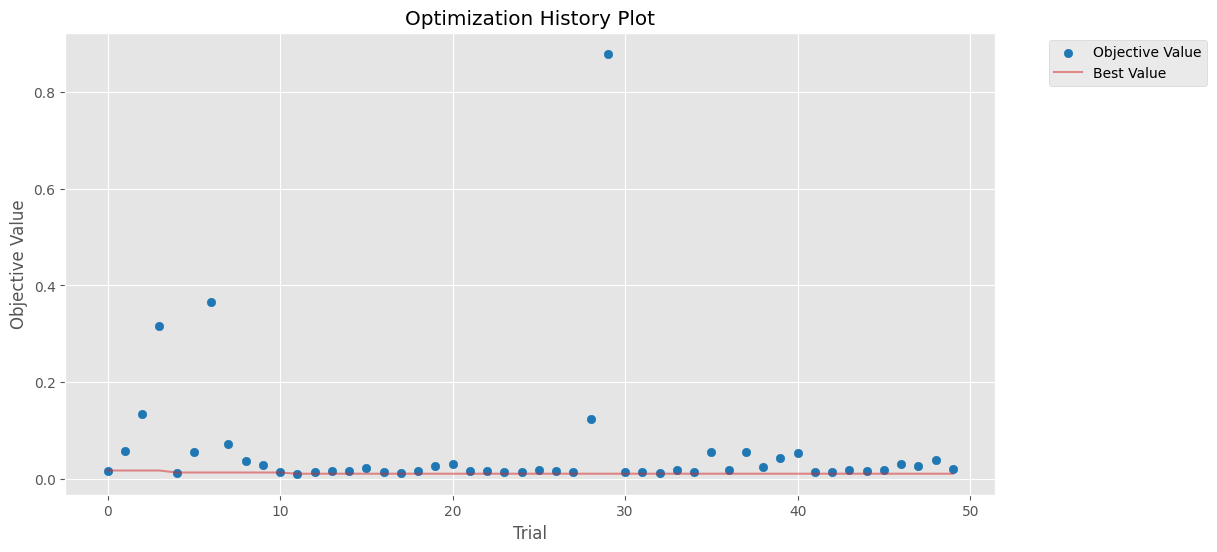

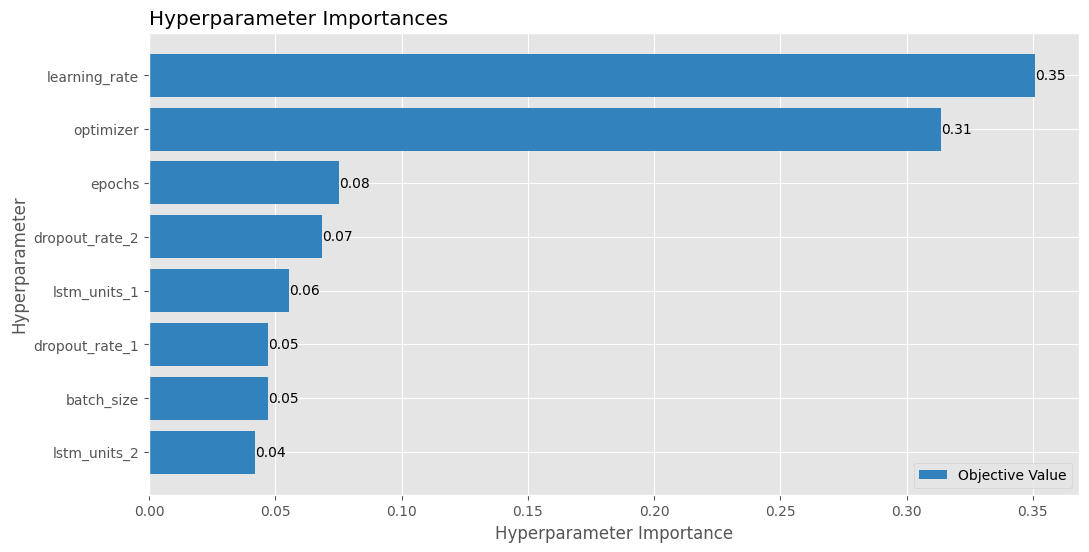

In [15]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [16]:
# Train final model with best parameters
best_params = study.best_params
model =  Sequential([
    LSTM(units=best_params['lstm_units_1'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate_1']),
    LSTM(units=best_params['lstm_units_2']),
    Dropout(best_params['dropout_rate_2']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.1027 - val_loss: 0.0025
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0191 - val_loss: 0.0029
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0158 - val_loss: 0.0037
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0156 - val_loss: 0.0167
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0147 - val_loss: 0.0030
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0106 - val_loss: 0.0044
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0099 - val_loss: 0.0064
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 9/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0092 - val_loss: 0.0041
Epoch 10/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0086 - val_loss: 0.0034
Epoch 11/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0084 - val_loss: 0.0030
Epoch 12/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0081 - val_l

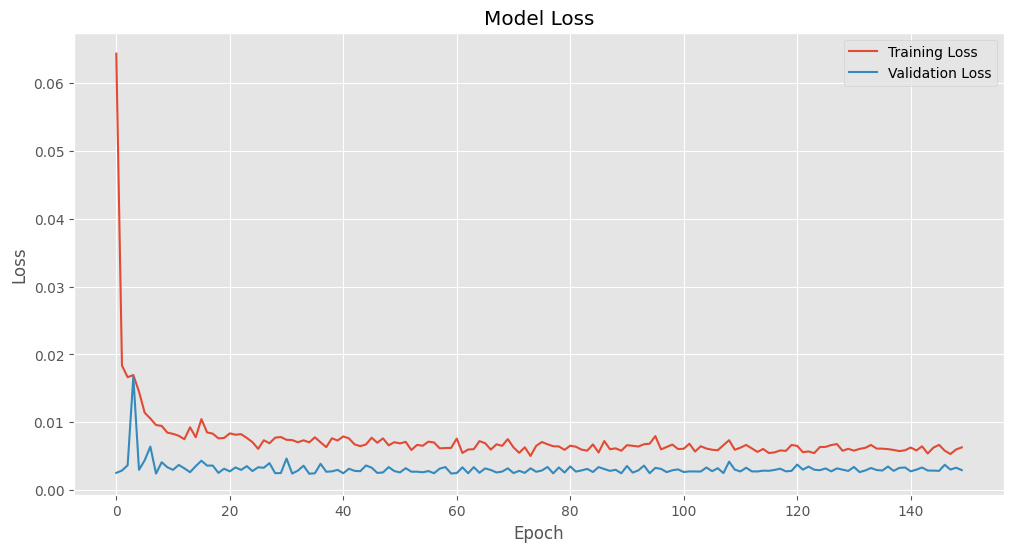

Average Loss: 0.0074


In [17]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [18]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [19]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [21]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 174.738
Root Mean Square Error: 239.641
Mean Absolute Percentage Error: 9.234%

evaluasi model data test:
Mean Absolute Error: 163.401
Root Mean Square Error: 207.320
Mean Absolute Percentage Error: 15.496%



In [22]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

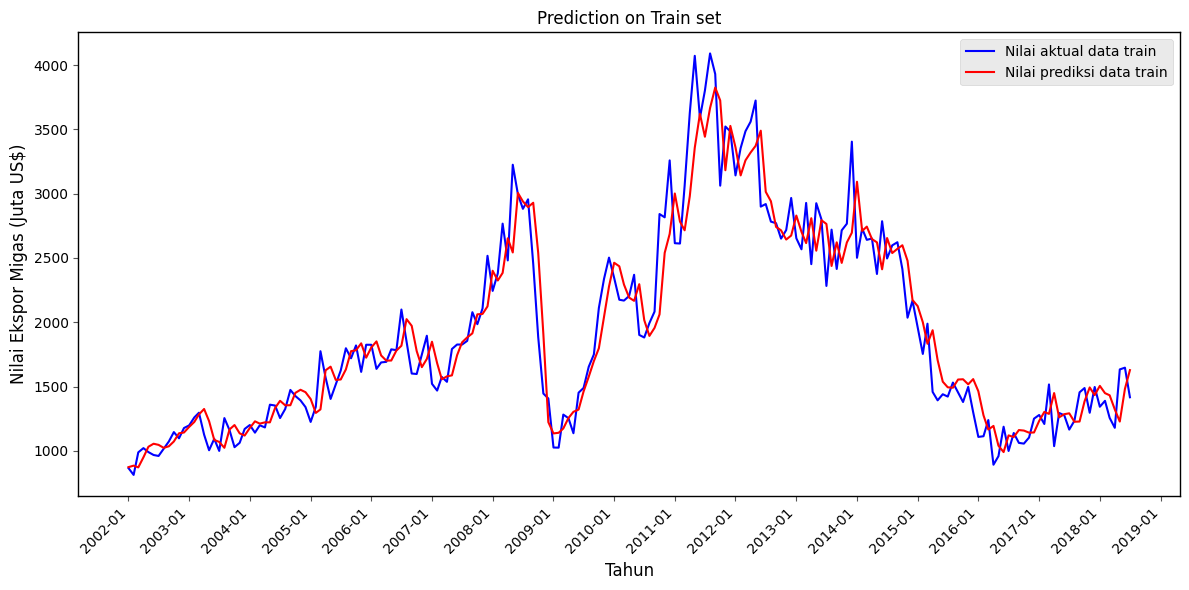

In [23]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

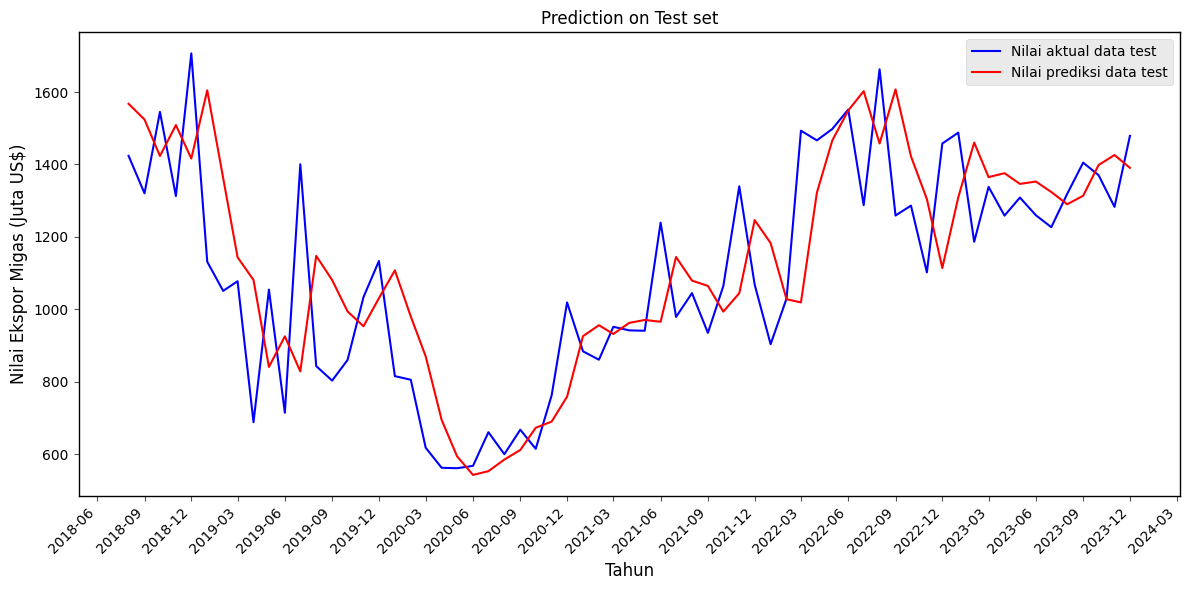

In [24]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

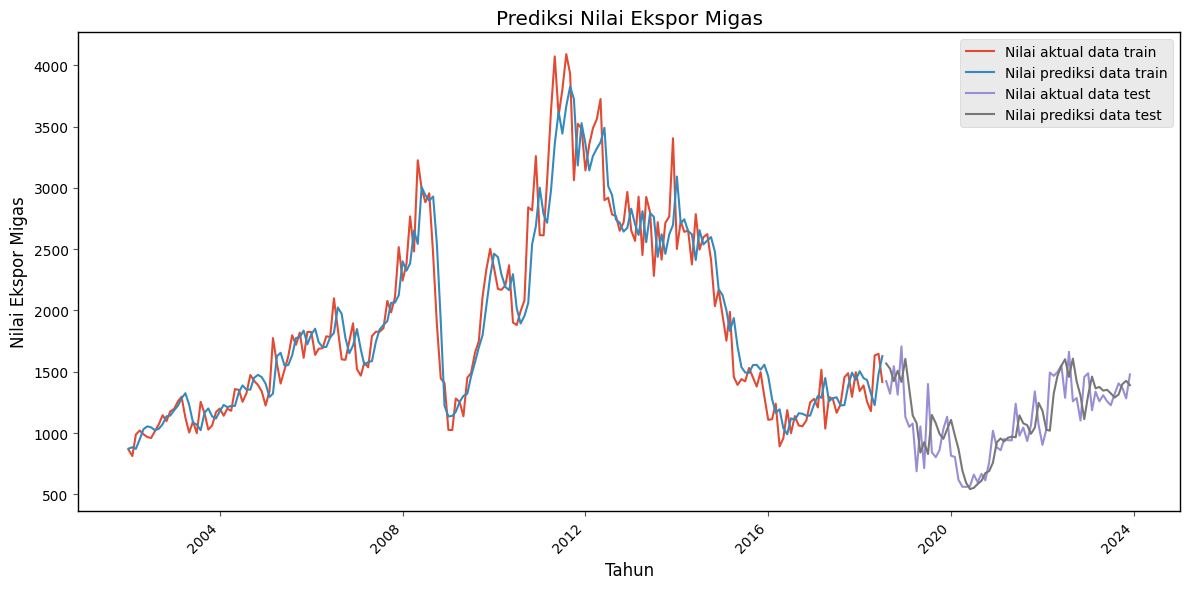

In [25]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1470.130981
1  2024-02-01                     1505.754883
2  2024-03-01                     1545.938477
3  2024-04-01                     1580.694336
4  2024-05-01                     1615.603516
5  2024-06-01                     1647.428101
6  2024-07-01                     1679.978638
7  2024-08-01                     1713.285278
8  2024-09-01                     1743.039185
9  2024-10-01                     1769.245361
10 2024-11-01                     179

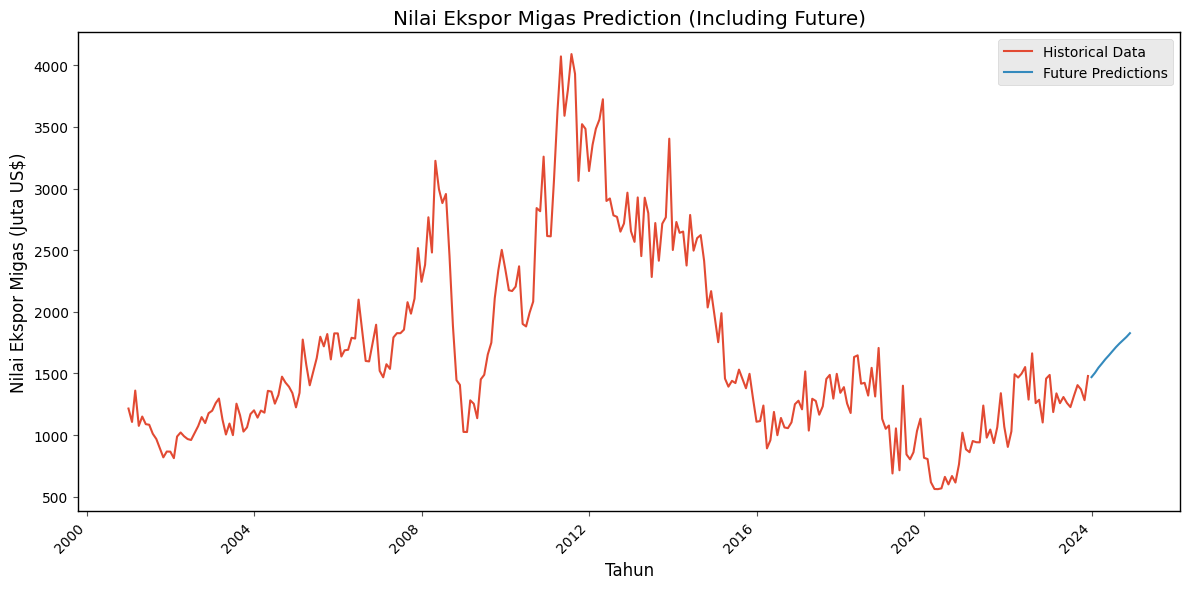

In [26]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()

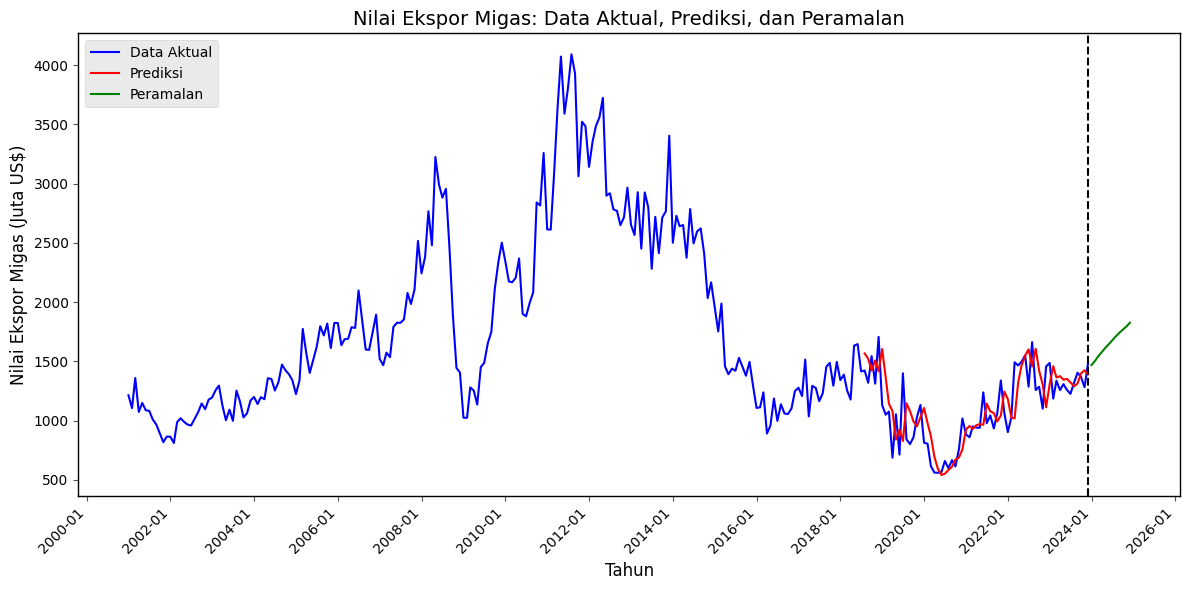

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [28]:
!pip install openpyxl

In [29]:
forecast_df.to_excel('forecast_75:25_h2t12.xlsx', index=False)
from google.colab import files
files.download('forecast_75:25_h2t12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_75:25_h2t12.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_75:25_h2t12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>